# **AIR PRESSURE SYSTEM FAILURE IN SCANIA TRUCKS**

**Context:**

The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes. The datasets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts.

**Content:**

The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

**Source:** https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. Default stable version is now 0.14.  Nightly is now 0.15.  We have fixed the long conda install.  Hooray!
2. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.15, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  If you have any issues with or suggestions for RAPID

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9ecb8e28-fc76-7481-7af2-4d3de2c801bf)


In [ ]:
# import libraries
import cudf as gdf # cudf is imported in parallel with pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Storing the data in GPU and CPU memory

gpu_train = gdf.read_csv("/content/drive/My Drive/Scania_Trucks_Data/aps_failure_training_set_processed_8bit.csv")
gpu_test = gdf.read_csv("/content/drive/My Drive/Scania_Trucks_Data/aps_failure_test_set_processed_8bit.csv")

cpu_train = pd.read_csv("/content/drive/My Drive/Scania_Trucks_Data/aps_failure_training_set_processed_8bit.csv")
cpu_test = pd.read_csv("/content/drive/My Drive/Scania_Trucks_Data/aps_failure_test_set_processed_8bit.csv")

In [ ]:
# Checking the dataframe shape 

gpu_train.shape, gpu_test.shape, cpu_train.shape, cpu_test.shape

((60000, 171), (16000, 171), (60000, 171), (16000, 171))

In [ ]:
gpu_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992187,0.117188,-0.289063,0.992187,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,-0.171875,0.101563,0.515625,0.359375,-0.046875,-0.03125,0.171875,-0.054688,-0.023438,-0.023438,0.546875,-0.203125,-0.140625,-0.023438,-0.03125,-0.187500,0.242188,0.296875,0.093750,0.359375,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992187,-0.179688,-0.289063,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,-0.179688,-0.140625,0.015625,0.015625,-0.015625,-0.03125,-0.101563,-0.054688,-0.023438,-0.023438,0.101563,-0.203125,-0.140625,-0.023438,-0.03125,-0.171875,0.179688,0.195312,-0.031250,0.015625,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992187,-0.125000,-0.289063,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,-0.179688,-0.226562,0.062500,-0.140625,-0.109375,-0.03125,-0.140625,-0.054688,-0.023438,-0.023438,-0.265625,-0.203125,-0.140625,-0.023438,-0.03125,-0.218750,-0.132812,-0.156250,-0.195312,-0.125000,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992187,-0.406250,-0.289063,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,-0.117188,-0.179688,-0.335938,-0.421875,-0.351563,-0.164062,-0.03125,-0.429688,-0.054688,-0.023438,-0.023438,-0.289063,-0.195312,-0.140625,-0.023438,-0.03125,-0.242188,-0.406250,-0.414063,-0.296875,-0.304688,-0.382813,-0.382813,-0.375000,-0.351563,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992187
4,-0.992187,0.007812,-0.289063,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,-0.117188,-0.164062,0.257813,0.039062,-0.257813,-0.140625,-0.03125,0.039062,-0.054688,-0.015625,-0.023438,-0.250000,-0.179688,0.289063,-0.023438,-0.03125,0.148438,-0.109375,-0.117188,-0.132812,0.046875,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


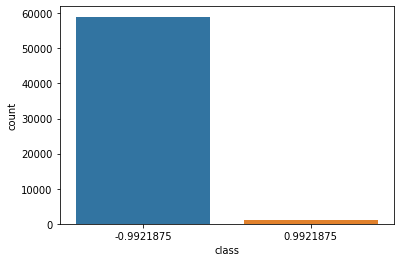

In [ ]:
sns.countplot(x = cpu_train['class'])

**Observations:**

The dataset is imbalanced as we can see from the countplot. The the accuracy metrics that are obtained will not be suitable to make a judgement about the performance of the model. Thus we must depend on the precision and recall metrics for model evaluation. 


In [ ]:
gpu_train['class'].value_counts()

-0.992187    59000
 0.992187     1000
Name: class, dtype: int32

In [ ]:
gpu_train.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [ ]:
# splitting the data into features and labels 
# both dataframes i.e cpu dataframe and gpu dataframe are split

y_cpu = cpu_train['class'].copy()
x_cpu = cpu_train.drop("class", inplace = False, axis = 1)

y_gpu = gpu_train['class'].copy()
x_gpu = gpu_train.drop("class", inplace = False, axis = 1)

In [ ]:
y_cpu.shape, x_cpu.shape

((60000,), (60000, 170))

In [ ]:
cpu_train.groupby('class').mean()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-0.992188,-0.142102,-0.073817,-0.200166,-0.007749,-0.033573,-0.040725,-0.007086,-0.029891,-0.047548,-0.083595,-0.109502,-0.130693,-0.111718,-0.095686,-0.058384,-0.019584,-0.147037,-0.039903,-0.020648,-0.021942,-0.072393,-0.072749,-0.14519,-0.145062,-0.132825,-0.129204,-0.069673,-0.007614,-0.026930,-0.015289,-0.062357,-0.089216,-0.029553,-0.014477,-0.021984,-0.028393,-0.028222,-0.041691,-0.085189,-0.109714,...,-0.023829,-0.126890,-0.112066,-0.069431,-0.021042,-0.027069,-0.006120,-0.069416,-0.007221,-0.028727,-0.021794,-0.029145,-0.130882,-0.108930,-0.120388,-0.040040,-0.100979,-0.127604,-0.127580,-0.118902,-0.099409,-0.109326,-0.080358,-0.020447,-0.025377,-0.108978,-0.122051,-0.124238,-0.113863,-0.105032,-0.118955,-0.112202,-0.108168,-0.102322,-0.115739,-0.097409,-0.088271,-0.069129,-0.020294,-0.018617
0.992188,0.907352,0.087953,-0.101938,-0.007055,-0.028188,-0.035211,0.023000,0.189102,0.363398,0.446008,0.582055,0.782195,0.550703,0.375453,0.250844,0.039266,0.890633,0.211719,0.021719,0.021578,0.514078,0.524477,0.88857,0.885172,0.876102,0.875344,0.181344,-0.001813,0.054031,0.005305,0.307164,0.243320,0.026180,0.038984,0.048594,0.049180,0.075500,0.173781,0.128438,0.608422,...,-0.064891,0.636687,0.633820,0.416125,0.053383,0.052945,0.006562,0.146055,-0.007734,-0.028180,-0.023047,-0.030227,0.888016,0.492625,0.480867,0.131117,0.187102,0.611383,0.604602,0.294234,0.348680,0.179086,0.169773,-0.005227,-0.012000,0.458328,0.640242,0.638250,0.770563,0.706930,0.729812,0.695898,0.683312,0.683375,0.626156,0.409469,0.135531,0.030344,-0.004781,-0.006633


# **PCA Visualization**

In [ ]:
from cuml import PCA

In [ ]:
X_gpu_data = x_gpu.copy()

In [ ]:
%%time 
pca = PCA(n_components=2)
components = pca.fit_transform(X_gpu_data)
components.shape

CPU times: user 599 ms, sys: 299 ms, total: 899 ms
Wall time: 900 ms


In [ ]:
type(components)

cudf.core.dataframe.DataFrame

In [ ]:
# for visualization we need to transfer data again to CPU
pca_dataframe = components.to_pandas() 

In [ ]:
pca_dataframe.columns = ['component1', 'component2']

Text(0.5, 1.0, '2D Visualization of data using PCA')

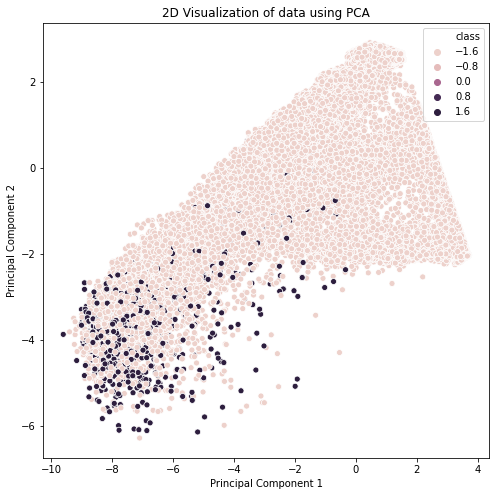

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x= 'component1', y = 'component2', hue = y_cpu, data = pca_dataframe)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of data using PCA')

# **tSNE Visualizaton**

In [ ]:
# In scikit-learn this can be implemented in a following way
# from sklearn.manifold import TSNE
from cuml import TSNE

In [ ]:
# we take x_gpu data for visualizing it in tSNE format    
tsne = TSNE(n_components = 2)
tsne_data = tsne.fit_transform(x_gpu)

In [ ]:
tsne_dataframe = gdf.DataFrame(tsne_data, columns = ['tsne_Component1','tsne_Component2'])

In [ ]:
temp_tsne_data = tsne_dataframe.to_pandas()
temp_tsne_data.columns =  ['tsne_Component1','tsne_Component2']

Text(0.5, 1.0, '2D Visualization of data using tSNE')

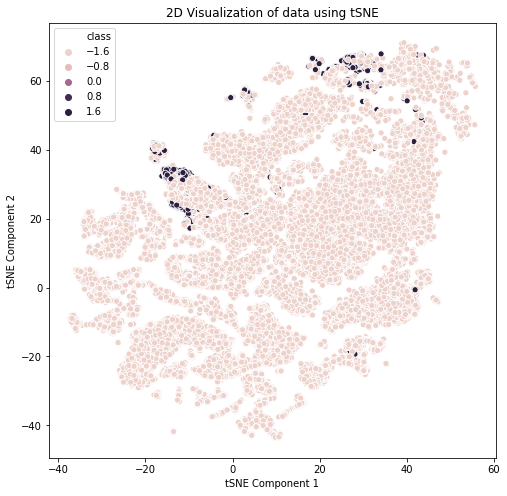

In [ ]:
plt.figure(figsize = (8,8))
sns.scatterplot(x= 'tsne_Component1', y = 'tsne_Component2', hue=y_cpu, data = temp_tsne_data)
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.title('2D Visualization of data using tSNE')

In [ ]:
y_cpu.unique()

array([-0.9921875,  0.9921875])

## **Splitting the Data into Training and Testing and Encoding**

In [ ]:
from cuml.preprocessing import LabelEncoder
import cupy as cp
# cupy is the replacement for numpy

In [ ]:
# from sklearn.model_selection import train_test_split
from cuml.preprocessing.model_selection import train_test_split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 10)

X_train = x_gpu
y_train = y_gpu

X_test = gpu_test.drop("class", inplace = False, axis = 1)
y_test = gpu_test["class"]

In [ ]:
le = LabelEncoder()
le.fit(y_train)  
y_train = le.transform(y_train)

le = LabelEncoder()
le.fit(y_test)  
y_test = le.transform(y_test)

In [ ]:
y_testC = y_test.to_pandas() 

In [ ]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')
y_testC = y_testC.astype('float64')

In [ ]:
print("Number of data points in Training Data :", X_train.shape)
print("Number of data points in Test Data :", X_test.shape)

Number of data points in Training Data : (60000, 170)
Number of data points in Test Data : (16000, 170)


In [ ]:
print("Number of labels in Training Data :", y_train.shape)
print("Number of labels in Test Data :", y_test.shape)

Number of labels in Training Data : (60000,)
Number of labels in Test Data : (16000,)


## **Machine Learning Models Implementation**



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
from cuml.linear_model import LogisticRegression
from tqdm import tqdm

**1) Logistic Regression**

In [ ]:
%%time

lamda = [10**x for x in range(-4,4,1)]
accuracies = []

for value in tqdm(lamda):
  clfLR = LogisticRegression(penalty = 'l2', C = value)
  clfLR.fit(X_train, y_train)
  y_predLR = clfLR.predict(X_test)
  y_predLRC = y_predLR.to_pandas()
  accuracies.append(accuracy_score(y_testC, y_predLRC))

100%|██████████| 8/8 [00:00<00:00, 16.88it/s]

CPU times: user 332 ms, sys: 137 ms, total: 469 ms
Wall time: 479 ms


In [ ]:
accuracies

[0.9765625,
 0.9765625,
 0.9765625,
 0.9765625,
 0.9765625,
 0.9765625,
 0.98225,
 0.9878125]

In [ ]:
best_lamda = lamda[accuracies.index(max(accuracies))]
clfLR = LogisticRegression(penalty = 'l2', C = best_lamda, max_iter = 1000)
clfLR.fit(X_train,y_train)
y_predLR = clfLR.predict(X_test)
y_predLRC = y_predLR.to_pandas()
print("Final Accuracy: ", accuracy_score(y_testC,y_predLRC))

Final Accuracy:  0.9878125


In [ ]:
print("Classification report of Logistic Regression Model")
print(classification_report(y_testC, y_predLRC))
print("Accuracy of Logistic Regression Model: ", accuracy_score(y_testC, y_predLRC))

Classification report of Logistic Regression Model
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.91      0.53      0.67       375

    accuracy                           0.99     16000
   macro avg       0.95      0.77      0.83     16000
weighted avg       0.99      0.99      0.99     16000

Accuracy of Logistic Regression Model:  0.9878125


**2) XG-Boost Classifier**

In [ ]:
import xgboost as xgb

In [ ]:
# Create train and test dmatrix
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
trained_model = xgb.train(
                        {
                          'learning_rate': 0.1,
                          'colsample_bytree' : 0.3,
                          'max_depth': 5,
                          'objective': 'multi:softmax',
                          'num_class': 6,
                          'n_estimators':300,
                          'alpha' : 10,
                          'silent': True,
                          'verbose_eval': False,
                          'tree_method':'gpu_hist',
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])

[21:34:34] WARNING: /conda/conda-bld/xgboost_1591204502249/work/src/learner.cc:480: 
Parameters: { n_estimators, silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00995
[1]	train-merror:0.00995
[2]	train-merror:0.01000
[3]	train-merror:0.00993
[4]	train-merror:0.00995
[5]	train-merror:0.00973
[6]	train-merror:0.00950
[7]	train-merror:0.00948
[8]	train-merror:0.00942
[9]	train-merror:0.00930
[10]	train-merror:0.00910
[11]	train-merror:0.00907
[12]	train-merror:0.00892
[13]	train-merror:0.00880
[14]	train-merror:0.00872
[15]	train-merror:0.00867
[16]	train-merror:0.00843
[17]	train-merror:0.00843
[18]	train-merror:0.00827
[19]	train-merror:0.00815
[20]	train-merror:0.00792
[21]	train-merror:0.00793
[22]	train-merror:0.00778
[23]	train-merror

In [ ]:
prediction = trained_model.predict(dtest)

In [ ]:
y_predXGC = cp.asnumpy(prediction)

In [ ]:
accuracy_score(y_testC,y_predXGC)

0.9905

In [ ]:
print("Classification report of XG-Boost Classification")
print(classification_report(y_testC, y_predXGC))
print("Accuracy of XG-Boost Model: ", accuracy_score(y_testC, y_predXGC))

Classification report of XG-Boost Classification
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.92      0.65      0.76       375

    accuracy                           0.99     16000
   macro avg       0.96      0.82      0.88     16000
weighted avg       0.99      0.99      0.99     16000

Accuracy of XG-Boost Model:  0.9905
